# Face alighment system solution using a convolutional neural network 

Imports and loading data

In [104]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import cv2
import os
import math
import csv
import random
from sklearn.model_selection import train_test_split

Loading data

In [105]:
# Load the data using np.load
data = np.load('training_images_full.npz', allow_pickle=True)

# Extract the images
images = data['images']
# and the data points
pts = data['points']

print(images.shape, pts.shape)

# Load the data that only has a subset of annotations using np.load
data = np.load('training_images_subset.npz', allow_pickle=True)

# Extract the images
images_subset = data['images']
# and the data points
pts_subset = data['points']

print(images_subset.shape, pts_subset.shape)

test_data = np.load('test_images.npz', allow_pickle=True)
test_images = test_data['images']
print(test_images.shape)

example_data = np.load('examples.npz', allow_pickle=True)
example_images = example_data['images']
print(example_images.shape)

(1425, 256, 256, 3) (1425, 44, 2)
(1386, 256, 256, 3) (1386, 5, 2)
(554, 256, 256, 3)
(6, 256, 256, 3)


Visualise the data

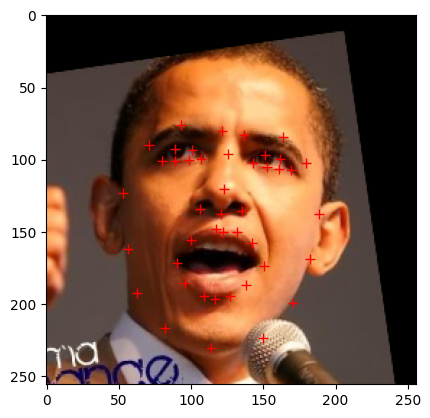

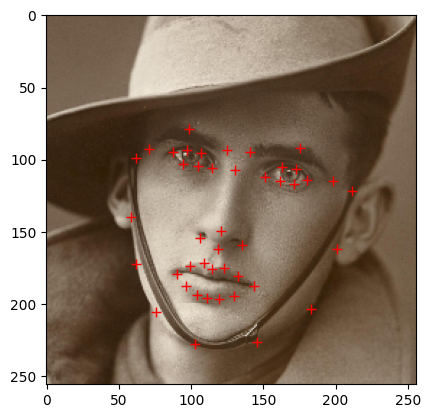

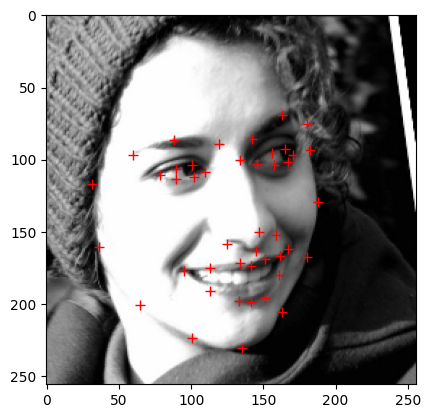

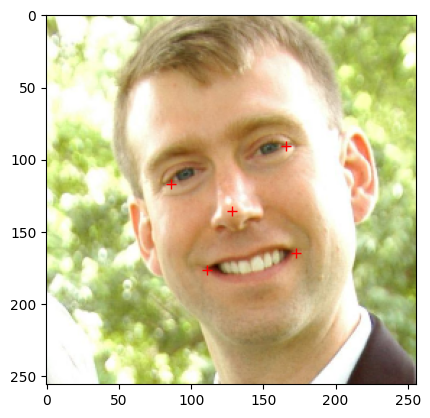

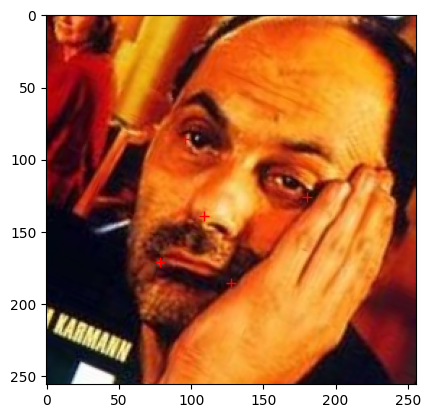

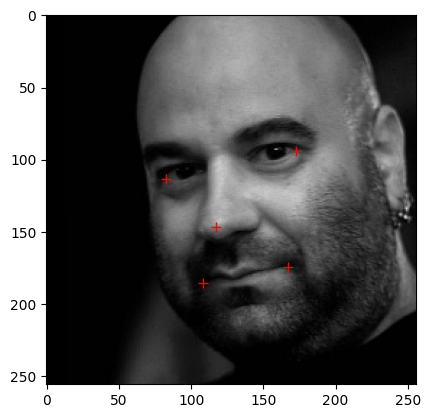

In [106]:
def visualise_pts(img, pts):
  plt.imshow(img)
  plt.plot(pts[:, 0], pts[:, 1], '+r', ms=7)
  plt.show()

for i in range(3):
  idx = np.random.randint(0, images.shape[0])
  visualise_pts(images[idx, ...], pts[idx, ...])

for i in range(3):
  idx = np.random.randint(0, images.shape[0])
  visualise_pts(images_subset[idx, ...], pts_subset[idx, ...])

# Data Augmentation and Pre-processing

Data augmentation and preprocessing: the data is augmented to increase the number of labelled samples we have and pixels are fixed to accomodate this

Data augmentation class containg all data augmentation methods I have chosen to use

In [159]:
class DataAugmentation():

    def __init__(self, _flip=True, _rotate=True, _shift_brightness=True, _add_noise=True):
        self._flip = _flip
        self._rotate = _rotate
        self._shift_brightness = _shift_brightness
        self._add_noise = _add_noise

    def flip(self, image, label):
        if np.random.rand() > 0.5:
            image = cv2.flip(image, 1)
            label[0] = 1 - label[0]
        return image, label

    def rotate(self, image, label, angle):
        M = cv2.getRotationMatrix2D((image.shape[1] / 2, image.shape[0] / 2), angle, 1)
        image = cv2.warpAffine(image, M, (image.shape[1], image.shape[0]))
        num_points = label.shape[0]
        points_hom = np.hstack((label, np.ones((num_points, 1))))
        # apply transformation matrix to points
        points_hom_rot = M.dot(points_hom.T).T
        # remove homogeneous coordinate (last column) from points
        points_rot = points_hom_rot[:, :2]
    
        return image, points_rot


    def shift_brightness(self, image, label):
        alpha = 1.0 + np.random.uniform(-0.1, 0.1)
        beta = np.random.uniform(30, 50)
        if image.ndim == 2:  # grayscale image
            image = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
        elif image.ndim == 3:  # color image
            channels = cv2.split(image)
            adjusted_channels = [cv2.convertScaleAbs(c, alpha=alpha, beta=beta) for c in channels]
            image = cv2.merge(adjusted_channels)
        return image, label


    def add_noise(self, image, label):
        noise = np.zeros(image.shape, np.uint8)
        cv2.randn(noise, np.zeros(3), np.ones(3) * 50)
        image = cv2.add(image, noise, dtype=cv2.CV_8UC3)
        return image, label


data_augmentation = DataAugmentation()

Examples of augmentation having been done

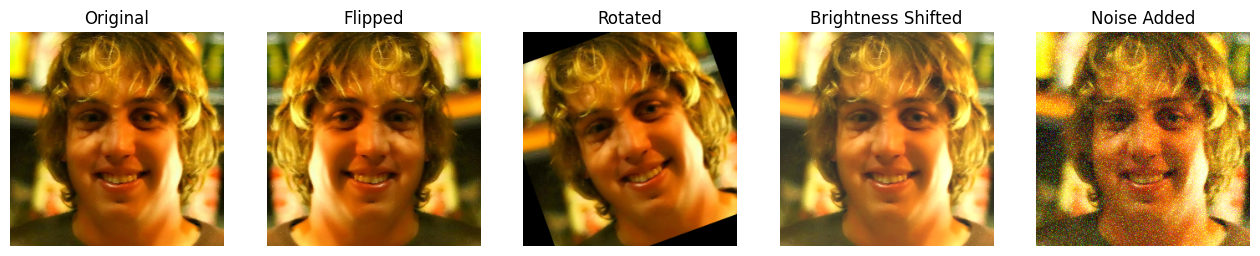

In [160]:
# original image and keypoints
image_orig, pts_orig = images[0], pts[0]
#pts_orig = pts[0]
# flip
image_flip, pts_flip = data_augmentation.flip(image_orig.copy(), pts_orig.copy())
# rotate
image_rotate, pts_rotate = data_augmentation.rotate(image_orig.copy(), pts_orig.copy(), 20)
# shift brightness
image_brightness, pts_brightness = data_augmentation.shift_brightness(image_orig.copy(), pts_orig.copy())
# add noise
image_noise, pts_noise = data_augmentation.add_noise(image_orig.copy(), pts_orig.copy())
# plot images with keypoints
fig, axes = plt.subplots(1, 5, figsize=(16, 4))

axes[0].imshow(image_orig)
axes[0].set_title("Original")

axes[1].imshow(image_flip)
axes[1].set_title("Flipped")

axes[2].imshow(image_rotate)
axes[2].set_title("Rotated")

axes[3].imshow(image_brightness)
axes[3].set_title("Brightness Shifted")

axes[4].imshow(image_noise)
axes[4].set_title("Noise Added")

for ax in axes:
    ax.axis("off")


In [161]:
#generate augmented dataset
def augmented_data_generator(images, points):

    # Create empty lists to store augmented images and points
    aug_images = []
    aug_pts = []

    # Loop over each image and its points
    for i, (image, points) in enumerate(zip(images, pts)):

        # Apply flip augmentation
        flip_image, flip_landmarks = data_augmentation.flip(image, points)
        aug_images.append(flip_image)
        aug_pts.append(flip_landmarks)

        # Apply rotation augmentation
        rotate_image, rotate_landmarks = data_augmentation.rotate(image, points, 20)
        aug_images.append(rotate_image)
        aug_pts.append(rotate_landmarks)

        # Apply brightness augmentation
        brightness_image, brightness_landmarks = data_augmentation.shift_brightness(image, points)
        aug_images.append(brightness_image)
        aug_pts.append(brightness_landmarks)

        # Apply noise augmentation
        noise_image, noise_landmarks = data_augmentation.add_noise(image, points)
        aug_images.append(noise_image)
        aug_pts.append(noise_landmarks)

    # Convert lists to numpy arrays
    aug_images = np.asarray(aug_images)
    aug_pts = np.asarray(aug_pts)

    return aug_images, aug_pts

# Here we generate the augmented dataset from our train_data

aug_images, aug_pts = augmented_data_generator(images, pts)
print('In our original training set we have {} images.'.format(len(images)))

print('In our augmented training set, we have {} images.'.format(len(aug_images)))


In our original training set we have 1425 images.
In our augmented training set, we have 5700 images.


Pre processting

In [162]:
#scales pixel values to a 0-1 range and resizes the image to a lower resolution of 122x122 pixels.
# This reduces the computational complexity of the CNN model and speeds up training.

def resize_img(img, pts=None):
    resized_images = []
    resized_points = []
    for i in range(img.shape[0]):
        resized = cv2.resize(img[i], (122, 122))
        resized_images.append(resized)
        if pts is not None:
            # scale the points accordingly
            scale_x = 122 / img.shape[2] 
            scale_y = 122 / img.shape[1] 
            pts[i,:,0] *= scale_x
            pts[i,:,1] *= scale_y
            resized_points.append(pts[i])
    resized_images = np.array(resized_images)
    if pts is None:
        return resized_images
    else:
        resized_points = np.array(resized_points)
        return resized_images, resized_points


#scales pixel values to range 0-1
def normalise_images_and_points(images, points=None):
    normalised_images = []
    normalised_points = []
    for i, img in enumerate(images):
        # normalise image
        img_norm = img / 255.0
        normalised_images.append(img_norm)

        # normalise points
        if points is not None:
            pts = points[i]
            pts_norm = pts.copy()
            pts_norm[:, 0] /= img.shape[1]
            pts_norm[:, 1] /= img.shape[0]
            normalised_points.append(pts_norm)

    if points is None:
        return np.array(normalised_images)
    else:
        return np.array(normalised_images), np.array(normalised_points)

We split the training dataset into training data to train our model and evaluation data which we can use to evaluate the model

In [163]:
def split_dataset(images, points, test_size=0.2, random_state=1):

    # check inputs are numpy arrays
    if not isinstance(images, np.ndarray) or not isinstance(points, np.ndarray):
        raise TypeError('Inputs must be numpy arrays.')

    # Split the inputted images and points into training and evaluation sets
    images_train, images_eval, pts_train, pts_evaluation = train_test_split(
        np.copy(images), np.copy(points), test_size=test_size, random_state=random_state)

    # groups the images and points into tuples
    train_data = np.array(list(zip(images_train, pts_train)), dtype='object')
    evaluation_data = np.array(list(zip(images_eval, pts_evaluation)), dtype='object')

    return train_data, evaluation_data

train_data, evaluation_data = split_dataset(images, pts)

Storing all pre-processing steps

In [214]:
#Image augmentations
aug_images, aug_pts = augmented_data_generator(images, pts)
#resizing images to 122x122
resized_images, resized_pts = resize_img(aug_images, aug_pts)
#normalising the point values
resized_normed_imgs, resized_normed_pts = normalise_images_and_points(resized_images, resized_pts)
#split dataset
training_dataset, evaluation_dataset = split_dataset(resized_normed_imgs, resized_normed_pts)

train_images = np.array([item[0] for item in training_dataset])
train_points = np.array([item[1] for item in training_dataset])

eval_images = np.array([item[0] for item in evaluation_dataset])
eval_points = np.array([item[1] for item in evaluation_dataset])

print(train_images.shape)
print(eval_images.shape)
print(train_points.shape)
print(eval_points.shape)

(4560, 122, 122, 3)
(1140, 122, 122, 3)
(4560, 44, 2)
(1140, 44, 2)


Visualisation of all pre processing steps applied to our training dataset

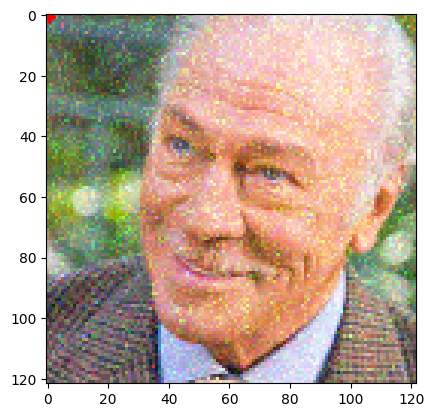

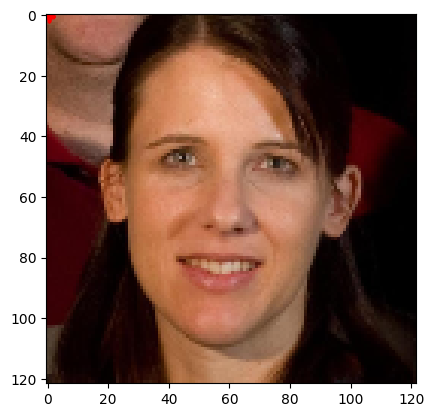

In [187]:
for i in range(2):
  idx = np.random.randint(0, train_images.shape[0])
  visualise_pts(train_images[idx, ...], train_points[idx, ...])

# Network architecture 

Building the cnn model

In [216]:
from keras.layers import Input, Dense, Conv2D, BatchNormalization, MaxPool2D, Flatten, Dropout, Reshape
from keras.models import Sequential

#
def build_CNN():
  # i have decided on an 8 layer model
  model = Sequential()
  
  model.add(Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=(122, 122, 3)))
  model.add(BatchNormalization())
  model.add(MaxPool2D(pool_size=(2, 2)))
  
  model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPool2D(pool_size=(2, 2)))
  
  model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPool2D(pool_size=(2, 2)))
  
  model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPool2D(pool_size=(2, 2)))
  
  model.add(Flatten())
  model.add(Dense(512, activation='relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))
  
  model.add(Dense(256, activation='relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))
  
  model.add(Dense(88, activation='sigmoid'))
  model.add(Reshape((44, 2)))


  # MSE loss function for its efficiency
  # Adam optimiser has an adaptive learning rate
  model.compile(loss='mean_squared_error', optimizer='adam')

  return model

CNN_model = build_CNN()

Model visualisation

In [ ]:
import pydot
import graphviz
from keras.utils.vis_utils import model_to_dot

graph = model_to_dot(CNN_model, show_shapes=True, show_layer_names=True)
pydot_graph = pydot.graph_from_dot_data(graph.to_string())[0]
graph_3d = graphviz.Source(pydot_graph, format='png')#
graph_3d.view()

# Training the model

In [218]:
#including early stopping if the validation accuracy stops increasing after 5 epochs
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min')
print(train_points.shape)
CNN_model.fit(train_images, train_points, 
                batch_size=32, epochs=10, 
                validation_data=(eval_images, eval_points))


(4560, 44, 2)
Epoch 1/10
143/143 [==============================] - 156s 1s/step - loss: 0.0619 - val_loss: 0.0077
Epoch 2/10
143/143 [==============================] - 162s 1s/step - loss: 0.0176 - val_loss: 0.0080
Epoch 3/10
143/143 [==============================] - 167s 1s/step - loss: 0.0130 - val_loss: 0.0067
Epoch 4/10
 30/143 [=====>........................] - ETA: 2:07 - loss: 0.0116

# Testing

Creating prediction results

In [ ]:
# get predictions, returns 34 points
def get_predictions(img, model):
  #first preprocess the image
  test_resized = resize_img(img)
  test_resized_normed = normalise_images_and_points(test_resized)

  #then make the predictions with the model
  predictions = np.squeeze(model.predict(test_resized_normed))  # remove the extra dimension
  #multiply the predictions by 244 to put them back to their original size
  predictions = predictions * 244

  return predictions[:34]  


In [208]:
def save_as_csv(points, location = '.'):
    """
    Save the points out as a .csv file
    :param points: numpy array of shape (no_test_images, no_points, 2) to be saved
    :param location: Directory to save results.csv in. Default to current working directory
    """
    assert points.shape[0]==554, 'wrong number of image points, should be 554 test images'
    assert np.prod(points.shape[1:])==44*2, 'wrong number of points provided. There should be 34 points with 2 values (x,y) per point'
    np.savetxt(location + '/results.csv', np.reshape(points, (points.shape[0], -1)), delimiter=',')

points = []
for i in range(len(test_images)):
  predictions = get_predictions(test_images, CNN_model)
  points.append(predictions)
  print(f"Number of points for image {i+1}: {len(predictions)//2}")
  print(points[-1].shape)

points = np.array(points)
save_as_csv(points)

18/18 [==============================] - 4s 230ms/step
Number of points for image 1: 277
(554, 44, 2)
18/18 [==============================] - 4s 215ms/step
Number of points for image 2: 277
(554, 44, 2)
18/18 [==============================] - 5s 252ms/step
Number of points for image 3: 277
(554, 44, 2)
18/18 [==============================] - 5s 258ms/step
Number of points for image 4: 277
(554, 44, 2)
18/18 [==============================] - 8s 439ms/step
Number of points for image 5: 277
(554, 44, 2)
18/18 [==============================] - 8s 428ms/step
Number of points for image 6: 277
(554, 44, 2)
18/18 [==============================] - 8s 434ms/step
Number of points for image 7: 277
(554, 44, 2)
18/18 [==============================] - 8s 427ms/step
Number of points for image 8: 277
(554, 44, 2)
18/18 [==============================] - 8s 433ms/step
Number of points for image 9: 277
(554, 44, 2)
18/18 [==============================] - 8s 440ms/step
Number of points for image 

KeyboardInterrupt: 

In [ ]:
# visualise test predictions
for i in range(3):
  idx = np.random.randint(0, test_images.shape[0])
  visualise_pts(test_images[idx, ...], points[idx, ...])

# Evaluation

In [ ]:
#euclidian distance provided
def euclid_dist(pred_pts, gt_pts):
  """
  Calculate the euclidean distance between pairs of points
  :param pred_pts: The predicted points
  :param gt_pts: The ground truth points
  :return: An array of shape (no_points,) containing the distance of each predicted point from the ground truth
  """
  import numpy as np
  pred_pts = np.reshape(pred_pts, (-1, 2))
  gt_pts = np.reshape(gt_pts, (-1, 2))
  return np.sqrt(np.sum(np.square(pred_pts - gt_pts), axis=-1))

Quantitative Analysis

Qualitative Analysis

# CNN model applied to subset

# Evaluation on point subset